In [56]:
import os
from math import sqrt

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import catboost as ctb

%matplotlib inline

In [57]:
ctb.version.VERSION

'0.12.1'

In [58]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [59]:
CSV_SAVE_PATH="./data/data_frames/"

In [60]:
original_test = pd.read_csv("test.csv",index_col=0)
original_train = pd.read_csv("train.csv",index_col=0)

In [61]:
train_test_ds = pd.read_csv(
    os.path.join(
        CSV_SAVE_PATH,
        "final_train_data_counts.csv"
   ),
    index_col=0
)

In [62]:
def add_drop_col(df: pd.DataFrame, df_orig: pd.DataFrame):
    loc = list(set(df_orig.index)-set(df.index))
    res_df = pd.concat([df,df_orig.loc[loc]])
    res_df = res_df.sort_index()
    return res_df
def fill_na(df: pd.DataFrame,feature: list):
    for f in feature:
        feat_v = df[f]
        if feat_v.isna().any():
            median = np.mean(feat_v.dropna())
            df[f] = feat_v.fillna(median)

In [63]:
train=add_drop_col(train_test_ds[train_test_ds.train==True],original_train)
train.train=True
test=add_drop_col(train_test_ds[train_test_ds.train==False],original_test)
test.train=False
train_test_ds = pd.concat([train,test])
train_test_ds=train_test_ds.reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
feauture = ['atm_group', 'lat','long', 'locality',                            
            'province', 'road', 'type', 'dist0', 'dist1',  
            'dist2', 'dist3', 'dist4', 'dist5', 'dist6', 'neib_g0', 'neib_g1',
            'neib_g2', 'neib_g3', 'neib_g4', 'neib_g5', 'neib_g6','count','mean']
                                                                              
cat_feature = ['atm_group', 'locality', 'province',                           
               'road', 'type','neib_g0', 'neib_g1',
            'neib_g2', 'neib_g3', 'neib_g4', 'neib_g5', 'neib_g6','count']                                        

In [65]:
def com_cat_feat(df: pd.DataFrame):
    le = preprocessing.LabelEncoder()
    le.fit(df.atm_group[~df.atm_group.isna()])
    for f in ['atm_group','neib_g0', 'neib_g1',
            'neib_g2', 'neib_g3', 'neib_g4', 'neib_g5', 'neib_g6']:
        df[f][~df[f].isna()]=le.transform(df[f][~df[f].isna()])
    for f in ['locality', 'province',                       
               'road', 'type']:
        not_na_f = df[f].dropna()
        le.fit(not_na_f)
        df[f][~df[f].isna()]=le.transform(not_na_f)

com_cat_feat(train_test_ds)

fill_na(train_test_ds,feauture)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [66]:
train_test_ds['count']=train_test_ds['count'].clip(0,6)

In [67]:
for f in cat_feature:
    train_test_ds[f]=train_test_ds[f].astype('int')

In [108]:
categorical_features_indices=[]
for idx,el in enumerate(feauture):
    if el in cat_feature:
        categorical_features_indices.append(idx)

In [69]:
y=train_test_ds[train_test_ds.train==True].target

In [70]:
X_tr,X_te = train_test_ds[
    train_test_ds.train==True
][feauture],\
train_test_ds[
    train_test_ds.train==False
][feauture]

In [71]:
from sklearn.model_selection import ShuffleSplit

In [72]:
stsh = ShuffleSplit(n_splits=8,random_state=1020,test_size=0.1)

In [106]:
%pdb

Automatic pdb calling has been turned ON


In [109]:
np.random.seed(12345)
models = []
skf_idx = [(train_idx, test_idx) for train_idx, test_idx in stsh.split(X_tr)]
# for train_idx,test_idx in tqdm.tqdm_notebook(stsh.split(X_tr)):
for train_idx, test_idx in tqdm.tqdm_notebook(skf_idx):
    print(len(train_idx), len(test_idx))
    X_train, X_valid, y_train, y_valid = \
    X_tr.iloc[train_idx], X_tr.iloc[test_idx], y.iloc[train_idx], y.iloc[
            test_idx]
    gbm = ctb.CatBoostRegressor(iterations=1000,
                                learning_rate=0.1,
                                max_depth=5 + np.random.randint(1, 5),
                                colsample_bylevel=0.8,
                                early_stopping_rounds=60)

    gbm.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            cat_features=categorical_features_indices)
    models.append(gbm)

5634 627
0:	learn: 0.0803984	test: 0.0805139	best: 0.0805139 (0)	total: 64.7ms	remaining: 1m 4s
1:	learn: 0.0753768	test: 0.0752536	best: 0.0752536 (1)	total: 130ms	remaining: 1m 5s
2:	learn: 0.0712129	test: 0.0708737	best: 0.0708737 (2)	total: 210ms	remaining: 1m 9s
3:	learn: 0.0675926	test: 0.0671076	best: 0.0671076 (3)	total: 242ms	remaining: 1m
4:	learn: 0.0643985	test: 0.0637019	best: 0.0637019 (4)	total: 282ms	remaining: 56.2s
5:	learn: 0.0618127	test: 0.0609735	best: 0.0609735 (5)	total: 297ms	remaining: 49.3s
6:	learn: 0.0594415	test: 0.0583902	best: 0.0583902 (6)	total: 377ms	remaining: 53.5s
7:	learn: 0.0575996	test: 0.0563878	best: 0.0563878 (7)	total: 396ms	remaining: 49.1s
8:	learn: 0.0558540	test: 0.0544670	best: 0.0544670 (8)	total: 458ms	remaining: 50.4s
9:	learn: 0.0544468	test: 0.0529453	best: 0.0529453 (9)	total: 527ms	remaining: 52.2s
10:	learn: 0.0531945	test: 0.0515187	best: 0.0515187 (10)	total: 598ms	remaining: 53.7s
11:	learn: 0.0521898	test: 0.0503375	best: 0.

95:	learn: 0.0442289	test: 0.0417304	best: 0.0417304 (95)	total: 5.05s	remaining: 47.5s
96:	learn: 0.0442144	test: 0.0417150	best: 0.0417150 (96)	total: 5.11s	remaining: 47.5s
97:	learn: 0.0441941	test: 0.0417165	best: 0.0417150 (96)	total: 5.17s	remaining: 47.6s
98:	learn: 0.0441516	test: 0.0417046	best: 0.0417046 (98)	total: 5.23s	remaining: 47.6s
99:	learn: 0.0441406	test: 0.0416997	best: 0.0416997 (99)	total: 5.31s	remaining: 47.8s
100:	learn: 0.0441144	test: 0.0417392	best: 0.0416997 (99)	total: 5.34s	remaining: 47.5s
101:	learn: 0.0440858	test: 0.0417416	best: 0.0416997 (99)	total: 5.4s	remaining: 47.5s
102:	learn: 0.0440268	test: 0.0417317	best: 0.0416997 (99)	total: 5.45s	remaining: 47.5s
103:	learn: 0.0439847	test: 0.0417234	best: 0.0416997 (99)	total: 5.53s	remaining: 47.7s
104:	learn: 0.0439569	test: 0.0417185	best: 0.0416997 (99)	total: 5.64s	remaining: 48.1s
105:	learn: 0.0439326	test: 0.0417014	best: 0.0416997 (99)	total: 5.71s	remaining: 48.2s
106:	learn: 0.0438682	test:

189:	learn: 0.0414738	test: 0.0411316	best: 0.0411272 (180)	total: 11.9s	remaining: 50.5s
190:	learn: 0.0414679	test: 0.0411328	best: 0.0411272 (180)	total: 11.9s	remaining: 50.5s
191:	learn: 0.0414649	test: 0.0411310	best: 0.0411272 (180)	total: 12s	remaining: 50.4s
192:	learn: 0.0414266	test: 0.0411239	best: 0.0411239 (192)	total: 12.1s	remaining: 50.4s
193:	learn: 0.0414016	test: 0.0411366	best: 0.0411239 (192)	total: 12.1s	remaining: 50.4s
194:	learn: 0.0413966	test: 0.0411407	best: 0.0411239 (192)	total: 12.2s	remaining: 50.3s
195:	learn: 0.0413631	test: 0.0411304	best: 0.0411239 (192)	total: 12.2s	remaining: 50.2s
196:	learn: 0.0413557	test: 0.0411314	best: 0.0411239 (192)	total: 12.3s	remaining: 50.1s
197:	learn: 0.0413518	test: 0.0411316	best: 0.0411239 (192)	total: 12.4s	remaining: 50.2s
198:	learn: 0.0413052	test: 0.0411263	best: 0.0411239 (192)	total: 12.5s	remaining: 50.2s
199:	learn: 0.0412984	test: 0.0411265	best: 0.0411239 (192)	total: 12.5s	remaining: 50.1s
200:	learn: 

282:	learn: 0.0400451	test: 0.0410367	best: 0.0410122 (256)	total: 19s	remaining: 48s
283:	learn: 0.0400418	test: 0.0410332	best: 0.0410122 (256)	total: 19s	remaining: 48s
284:	learn: 0.0400370	test: 0.0410370	best: 0.0410122 (256)	total: 19.1s	remaining: 48s
285:	learn: 0.0400335	test: 0.0410399	best: 0.0410122 (256)	total: 19.2s	remaining: 47.9s
286:	learn: 0.0400190	test: 0.0410423	best: 0.0410122 (256)	total: 19.3s	remaining: 47.8s
287:	learn: 0.0400035	test: 0.0410386	best: 0.0410122 (256)	total: 19.3s	remaining: 47.8s
288:	learn: 0.0399790	test: 0.0410437	best: 0.0410122 (256)	total: 19.4s	remaining: 47.7s
289:	learn: 0.0399769	test: 0.0410440	best: 0.0410122 (256)	total: 19.5s	remaining: 47.7s
290:	learn: 0.0399316	test: 0.0410281	best: 0.0410122 (256)	total: 19.6s	remaining: 47.7s
291:	learn: 0.0399290	test: 0.0410297	best: 0.0410122 (256)	total: 19.7s	remaining: 47.7s
292:	learn: 0.0398982	test: 0.0410132	best: 0.0410122 (256)	total: 19.8s	remaining: 47.7s
293:	learn: 0.039894

377:	learn: 0.0389051	test: 0.0409549	best: 0.0409509 (368)	total: 26.1s	remaining: 43s
378:	learn: 0.0388799	test: 0.0409428	best: 0.0409428 (378)	total: 26.2s	remaining: 42.9s
379:	learn: 0.0388782	test: 0.0409443	best: 0.0409428 (378)	total: 26.2s	remaining: 42.8s
380:	learn: 0.0388631	test: 0.0409485	best: 0.0409428 (378)	total: 26.3s	remaining: 42.7s
381:	learn: 0.0388514	test: 0.0409451	best: 0.0409428 (378)	total: 26.4s	remaining: 42.7s
382:	learn: 0.0388423	test: 0.0409472	best: 0.0409428 (378)	total: 26.4s	remaining: 42.6s
383:	learn: 0.0388232	test: 0.0409408	best: 0.0409408 (383)	total: 26.5s	remaining: 42.5s
384:	learn: 0.0387909	test: 0.0409410	best: 0.0409408 (383)	total: 26.5s	remaining: 42.4s
385:	learn: 0.0387668	test: 0.0409491	best: 0.0409408 (383)	total: 26.6s	remaining: 42.4s
386:	learn: 0.0387607	test: 0.0409503	best: 0.0409408 (383)	total: 26.7s	remaining: 42.3s
387:	learn: 0.0387559	test: 0.0409491	best: 0.0409408 (383)	total: 26.8s	remaining: 42.3s
388:	learn: 

471:	learn: 0.0380245	test: 0.0408527	best: 0.0408409 (460)	total: 33.9s	remaining: 37.9s
472:	learn: 0.0380195	test: 0.0408511	best: 0.0408409 (460)	total: 34s	remaining: 37.9s
473:	learn: 0.0380139	test: 0.0408520	best: 0.0408409 (460)	total: 34.2s	remaining: 37.9s
474:	learn: 0.0380123	test: 0.0408524	best: 0.0408409 (460)	total: 34.3s	remaining: 37.9s
475:	learn: 0.0380083	test: 0.0408528	best: 0.0408409 (460)	total: 34.4s	remaining: 37.9s
476:	learn: 0.0380042	test: 0.0408515	best: 0.0408409 (460)	total: 34.5s	remaining: 37.9s
477:	learn: 0.0380031	test: 0.0408543	best: 0.0408409 (460)	total: 34.6s	remaining: 37.8s
478:	learn: 0.0379982	test: 0.0408542	best: 0.0408409 (460)	total: 34.7s	remaining: 37.7s
479:	learn: 0.0379978	test: 0.0408550	best: 0.0408409 (460)	total: 34.7s	remaining: 37.6s
480:	learn: 0.0379955	test: 0.0408591	best: 0.0408409 (460)	total: 34.8s	remaining: 37.6s
481:	learn: 0.0379805	test: 0.0408623	best: 0.0408409 (460)	total: 34.9s	remaining: 37.5s
482:	learn: 

565:	learn: 0.0373857	test: 0.0408410	best: 0.0408003 (539)	total: 40.4s	remaining: 31s
566:	learn: 0.0373845	test: 0.0408375	best: 0.0408003 (539)	total: 40.5s	remaining: 30.9s
567:	learn: 0.0373619	test: 0.0408263	best: 0.0408003 (539)	total: 40.5s	remaining: 30.8s
568:	learn: 0.0373540	test: 0.0408279	best: 0.0408003 (539)	total: 40.6s	remaining: 30.8s
569:	learn: 0.0373370	test: 0.0408217	best: 0.0408003 (539)	total: 40.7s	remaining: 30.7s
570:	learn: 0.0373157	test: 0.0408110	best: 0.0408003 (539)	total: 40.7s	remaining: 30.6s
571:	learn: 0.0373006	test: 0.0407940	best: 0.0407940 (571)	total: 40.8s	remaining: 30.5s
572:	learn: 0.0372867	test: 0.0407840	best: 0.0407840 (572)	total: 40.9s	remaining: 30.5s
573:	learn: 0.0372859	test: 0.0407837	best: 0.0407837 (573)	total: 41s	remaining: 30.4s
574:	learn: 0.0372845	test: 0.0407852	best: 0.0407837 (573)	total: 41s	remaining: 30.3s
575:	learn: 0.0372810	test: 0.0407839	best: 0.0407837 (573)	total: 41.1s	remaining: 30.2s
576:	learn: 0.03

657:	learn: 0.0366967	test: 0.0406576	best: 0.0406557 (656)	total: 46.3s	remaining: 24.1s
658:	learn: 0.0366820	test: 0.0406710	best: 0.0406557 (656)	total: 46.4s	remaining: 24s
659:	learn: 0.0366806	test: 0.0406712	best: 0.0406557 (656)	total: 46.5s	remaining: 23.9s
660:	learn: 0.0366769	test: 0.0406686	best: 0.0406557 (656)	total: 46.5s	remaining: 23.9s
661:	learn: 0.0366750	test: 0.0406724	best: 0.0406557 (656)	total: 46.6s	remaining: 23.8s
662:	learn: 0.0366637	test: 0.0406750	best: 0.0406557 (656)	total: 46.7s	remaining: 23.7s
663:	learn: 0.0366605	test: 0.0406748	best: 0.0406557 (656)	total: 46.7s	remaining: 23.6s
664:	learn: 0.0366532	test: 0.0406821	best: 0.0406557 (656)	total: 46.8s	remaining: 23.6s
665:	learn: 0.0366525	test: 0.0406836	best: 0.0406557 (656)	total: 46.8s	remaining: 23.5s
666:	learn: 0.0366473	test: 0.0406762	best: 0.0406557 (656)	total: 46.9s	remaining: 23.4s
667:	learn: 0.0366456	test: 0.0406772	best: 0.0406557 (656)	total: 47s	remaining: 23.3s
668:	learn: 0.

750:	learn: 0.0362238	test: 0.0406294	best: 0.0406279 (745)	total: 52.4s	remaining: 17.4s
751:	learn: 0.0362223	test: 0.0406314	best: 0.0406279 (745)	total: 52.5s	remaining: 17.3s
752:	learn: 0.0362219	test: 0.0406348	best: 0.0406279 (745)	total: 52.5s	remaining: 17.2s
753:	learn: 0.0362177	test: 0.0406347	best: 0.0406279 (745)	total: 52.6s	remaining: 17.2s
754:	learn: 0.0362039	test: 0.0406368	best: 0.0406279 (745)	total: 52.7s	remaining: 17.1s
755:	learn: 0.0361958	test: 0.0406339	best: 0.0406279 (745)	total: 52.8s	remaining: 17s
756:	learn: 0.0361956	test: 0.0406361	best: 0.0406279 (745)	total: 52.8s	remaining: 16.9s
757:	learn: 0.0361885	test: 0.0406442	best: 0.0406279 (745)	total: 52.9s	remaining: 16.9s
758:	learn: 0.0361881	test: 0.0406443	best: 0.0406279 (745)	total: 53s	remaining: 16.8s
759:	learn: 0.0361877	test: 0.0406448	best: 0.0406279 (745)	total: 53s	remaining: 16.7s
760:	learn: 0.0361866	test: 0.0406492	best: 0.0406279 (745)	total: 53.1s	remaining: 16.7s
761:	learn: 0.03

842:	learn: 0.0355045	test: 0.0405479	best: 0.0405350 (832)	total: 58.4s	remaining: 10.9s
843:	learn: 0.0355031	test: 0.0405496	best: 0.0405350 (832)	total: 58.4s	remaining: 10.8s
844:	learn: 0.0354997	test: 0.0405502	best: 0.0405350 (832)	total: 58.5s	remaining: 10.7s
845:	learn: 0.0354955	test: 0.0405518	best: 0.0405350 (832)	total: 58.6s	remaining: 10.7s
846:	learn: 0.0354946	test: 0.0405523	best: 0.0405350 (832)	total: 58.6s	remaining: 10.6s
847:	learn: 0.0354895	test: 0.0405575	best: 0.0405350 (832)	total: 58.7s	remaining: 10.5s
848:	learn: 0.0354722	test: 0.0405651	best: 0.0405350 (832)	total: 58.8s	remaining: 10.5s
849:	learn: 0.0354720	test: 0.0405650	best: 0.0405350 (832)	total: 58.8s	remaining: 10.4s
850:	learn: 0.0354629	test: 0.0405657	best: 0.0405350 (832)	total: 58.9s	remaining: 10.3s
851:	learn: 0.0354625	test: 0.0405661	best: 0.0405350 (832)	total: 59s	remaining: 10.2s
852:	learn: 0.0354599	test: 0.0405625	best: 0.0405350 (832)	total: 59s	remaining: 10.2s
853:	learn: 0.

48:	learn: 0.0454002	test: 0.0464675	best: 0.0464675 (48)	total: 1.54s	remaining: 29.8s
49:	learn: 0.0453594	test: 0.0464169	best: 0.0464169 (49)	total: 1.56s	remaining: 29.7s
50:	learn: 0.0452883	test: 0.0463566	best: 0.0463566 (50)	total: 1.61s	remaining: 29.9s
51:	learn: 0.0452585	test: 0.0463074	best: 0.0463074 (51)	total: 1.63s	remaining: 29.7s
52:	learn: 0.0452182	test: 0.0462651	best: 0.0462651 (52)	total: 1.65s	remaining: 29.6s
53:	learn: 0.0452075	test: 0.0462607	best: 0.0462607 (53)	total: 1.68s	remaining: 29.4s
54:	learn: 0.0452075	test: 0.0462607	best: 0.0462607 (54)	total: 1.68s	remaining: 28.9s
55:	learn: 0.0451596	test: 0.0462321	best: 0.0462321 (55)	total: 1.72s	remaining: 29s
56:	learn: 0.0451323	test: 0.0462389	best: 0.0462321 (55)	total: 1.77s	remaining: 29.3s
57:	learn: 0.0451029	test: 0.0462219	best: 0.0462219 (57)	total: 1.79s	remaining: 29.1s
58:	learn: 0.0450600	test: 0.0461964	best: 0.0461964 (58)	total: 1.83s	remaining: 29.2s
59:	learn: 0.0450107	test: 0.04616

145:	learn: 0.0427455	test: 0.0453351	best: 0.0453351 (145)	total: 4.91s	remaining: 28.7s
146:	learn: 0.0427102	test: 0.0453058	best: 0.0453058 (146)	total: 4.95s	remaining: 28.7s
147:	learn: 0.0426897	test: 0.0452911	best: 0.0452911 (147)	total: 4.99s	remaining: 28.7s
148:	learn: 0.0426795	test: 0.0452921	best: 0.0452911 (147)	total: 5.02s	remaining: 28.7s
149:	learn: 0.0426631	test: 0.0452782	best: 0.0452782 (149)	total: 5.06s	remaining: 28.7s
150:	learn: 0.0426551	test: 0.0452734	best: 0.0452734 (150)	total: 5.1s	remaining: 28.7s
151:	learn: 0.0426215	test: 0.0452551	best: 0.0452551 (151)	total: 5.15s	remaining: 28.7s
152:	learn: 0.0426113	test: 0.0452621	best: 0.0452551 (151)	total: 5.2s	remaining: 28.8s
153:	learn: 0.0425965	test: 0.0452749	best: 0.0452551 (151)	total: 5.23s	remaining: 28.7s
154:	learn: 0.0425595	test: 0.0452586	best: 0.0452551 (151)	total: 5.27s	remaining: 28.8s
155:	learn: 0.0425418	test: 0.0452624	best: 0.0452551 (151)	total: 5.31s	remaining: 28.7s
156:	learn: 

241:	learn: 0.0411406	test: 0.0450472	best: 0.0450472 (241)	total: 8.86s	remaining: 27.7s
242:	learn: 0.0411375	test: 0.0450480	best: 0.0450472 (241)	total: 8.9s	remaining: 27.7s
243:	learn: 0.0411211	test: 0.0450357	best: 0.0450357 (243)	total: 8.94s	remaining: 27.7s
244:	learn: 0.0411202	test: 0.0450304	best: 0.0450304 (244)	total: 8.98s	remaining: 27.7s
245:	learn: 0.0410908	test: 0.0450145	best: 0.0450145 (245)	total: 9.02s	remaining: 27.7s
246:	learn: 0.0410772	test: 0.0450250	best: 0.0450145 (245)	total: 9.07s	remaining: 27.6s
247:	learn: 0.0410465	test: 0.0450346	best: 0.0450145 (245)	total: 9.11s	remaining: 27.6s
248:	learn: 0.0410385	test: 0.0450277	best: 0.0450145 (245)	total: 9.15s	remaining: 27.6s
249:	learn: 0.0410352	test: 0.0450291	best: 0.0450145 (245)	total: 9.19s	remaining: 27.6s
250:	learn: 0.0410265	test: 0.0450249	best: 0.0450145 (245)	total: 9.23s	remaining: 27.5s
251:	learn: 0.0410181	test: 0.0450221	best: 0.0450145 (245)	total: 9.27s	remaining: 27.5s
252:	learn:

336:	learn: 0.0400520	test: 0.0448890	best: 0.0448826 (331)	total: 12.7s	remaining: 25.1s
337:	learn: 0.0400473	test: 0.0448952	best: 0.0448826 (331)	total: 12.8s	remaining: 25s
338:	learn: 0.0400346	test: 0.0449000	best: 0.0448826 (331)	total: 12.8s	remaining: 25s
339:	learn: 0.0400343	test: 0.0449017	best: 0.0448826 (331)	total: 12.9s	remaining: 25s
340:	learn: 0.0400149	test: 0.0449107	best: 0.0448826 (331)	total: 12.9s	remaining: 24.9s
341:	learn: 0.0400054	test: 0.0448927	best: 0.0448826 (331)	total: 12.9s	remaining: 24.9s
342:	learn: 0.0399954	test: 0.0448990	best: 0.0448826 (331)	total: 13s	remaining: 24.9s
343:	learn: 0.0399929	test: 0.0448996	best: 0.0448826 (331)	total: 13s	remaining: 24.8s
344:	learn: 0.0399898	test: 0.0449004	best: 0.0448826 (331)	total: 13.1s	remaining: 24.8s
345:	learn: 0.0399889	test: 0.0448999	best: 0.0448826 (331)	total: 13.1s	remaining: 24.8s
346:	learn: 0.0399643	test: 0.0449000	best: 0.0448826 (331)	total: 13.1s	remaining: 24.7s
347:	learn: 0.039958

429:	learn: 0.0389905	test: 0.0447976	best: 0.0447845 (414)	total: 16.5s	remaining: 21.9s
430:	learn: 0.0389871	test: 0.0448119	best: 0.0447845 (414)	total: 16.6s	remaining: 21.9s
431:	learn: 0.0389849	test: 0.0448182	best: 0.0447845 (414)	total: 16.6s	remaining: 21.8s
432:	learn: 0.0389801	test: 0.0448115	best: 0.0447845 (414)	total: 16.6s	remaining: 21.8s
433:	learn: 0.0389712	test: 0.0448078	best: 0.0447845 (414)	total: 16.7s	remaining: 21.7s
434:	learn: 0.0389688	test: 0.0448084	best: 0.0447845 (414)	total: 16.7s	remaining: 21.7s
435:	learn: 0.0389611	test: 0.0448090	best: 0.0447845 (414)	total: 16.8s	remaining: 21.7s
436:	learn: 0.0389461	test: 0.0447990	best: 0.0447845 (414)	total: 16.8s	remaining: 21.6s
437:	learn: 0.0389460	test: 0.0447991	best: 0.0447845 (414)	total: 16.8s	remaining: 21.6s
438:	learn: 0.0389452	test: 0.0447994	best: 0.0447845 (414)	total: 16.9s	remaining: 21.6s
439:	learn: 0.0389428	test: 0.0447985	best: 0.0447845 (414)	total: 16.9s	remaining: 21.5s
440:	learn

524:	learn: 0.0383500	test: 0.0446622	best: 0.0446622 (524)	total: 20.4s	remaining: 18.5s
525:	learn: 0.0383487	test: 0.0446619	best: 0.0446619 (525)	total: 20.5s	remaining: 18.4s
526:	learn: 0.0383453	test: 0.0446652	best: 0.0446619 (525)	total: 20.5s	remaining: 18.4s
527:	learn: 0.0383406	test: 0.0446657	best: 0.0446619 (525)	total: 20.5s	remaining: 18.4s
528:	learn: 0.0383397	test: 0.0446646	best: 0.0446619 (525)	total: 20.6s	remaining: 18.3s
529:	learn: 0.0383390	test: 0.0446661	best: 0.0446619 (525)	total: 20.6s	remaining: 18.3s
530:	learn: 0.0383310	test: 0.0446673	best: 0.0446619 (525)	total: 20.7s	remaining: 18.2s
531:	learn: 0.0383304	test: 0.0446687	best: 0.0446619 (525)	total: 20.7s	remaining: 18.2s
532:	learn: 0.0383295	test: 0.0446693	best: 0.0446619 (525)	total: 20.7s	remaining: 18.2s
533:	learn: 0.0383285	test: 0.0446689	best: 0.0446619 (525)	total: 20.8s	remaining: 18.1s
534:	learn: 0.0383269	test: 0.0446693	best: 0.0446619 (525)	total: 20.8s	remaining: 18.1s
535:	learn

617:	learn: 0.0378039	test: 0.0445813	best: 0.0445813 (617)	total: 24.1s	remaining: 14.9s
618:	learn: 0.0377884	test: 0.0445837	best: 0.0445813 (617)	total: 24.2s	remaining: 14.9s
619:	learn: 0.0377876	test: 0.0445848	best: 0.0445813 (617)	total: 24.2s	remaining: 14.8s
620:	learn: 0.0377844	test: 0.0445837	best: 0.0445813 (617)	total: 24.2s	remaining: 14.8s
621:	learn: 0.0377832	test: 0.0445841	best: 0.0445813 (617)	total: 24.3s	remaining: 14.8s
622:	learn: 0.0377768	test: 0.0445878	best: 0.0445813 (617)	total: 24.3s	remaining: 14.7s
623:	learn: 0.0377602	test: 0.0445784	best: 0.0445784 (623)	total: 24.4s	remaining: 14.7s
624:	learn: 0.0377586	test: 0.0445796	best: 0.0445784 (623)	total: 24.4s	remaining: 14.6s
625:	learn: 0.0377393	test: 0.0445840	best: 0.0445784 (623)	total: 24.4s	remaining: 14.6s
626:	learn: 0.0377284	test: 0.0445985	best: 0.0445784 (623)	total: 24.5s	remaining: 14.6s
627:	learn: 0.0377032	test: 0.0446026	best: 0.0445784 (623)	total: 24.5s	remaining: 14.5s
628:	learn

26:	learn: 0.0468935	test: 0.0452006	best: 0.0452006 (26)	total: 818ms	remaining: 29.5s
27:	learn: 0.0467630	test: 0.0450691	best: 0.0450691 (27)	total: 860ms	remaining: 29.9s
28:	learn: 0.0466631	test: 0.0449099	best: 0.0449099 (28)	total: 888ms	remaining: 29.7s
29:	learn: 0.0464981	test: 0.0447431	best: 0.0447431 (29)	total: 929ms	remaining: 30.1s
30:	learn: 0.0464282	test: 0.0446652	best: 0.0446652 (30)	total: 947ms	remaining: 29.6s
31:	learn: 0.0463103	test: 0.0446195	best: 0.0446195 (31)	total: 990ms	remaining: 30s
32:	learn: 0.0462516	test: 0.0445207	best: 0.0445207 (32)	total: 998ms	remaining: 29.2s
33:	learn: 0.0462220	test: 0.0444788	best: 0.0444788 (33)	total: 1.01s	remaining: 28.7s
34:	learn: 0.0461706	test: 0.0444756	best: 0.0444756 (34)	total: 1.05s	remaining: 28.9s
35:	learn: 0.0460958	test: 0.0443699	best: 0.0443699 (35)	total: 1.09s	remaining: 29.2s
36:	learn: 0.0460289	test: 0.0443638	best: 0.0443638 (36)	total: 1.11s	remaining: 28.8s
37:	learn: 0.0459884	test: 0.04431

120:	learn: 0.0439347	test: 0.0434042	best: 0.0434009 (119)	total: 3.78s	remaining: 27.4s
121:	learn: 0.0439049	test: 0.0433777	best: 0.0433777 (121)	total: 3.83s	remaining: 27.6s
122:	learn: 0.0438814	test: 0.0433654	best: 0.0433654 (122)	total: 3.86s	remaining: 27.5s
123:	learn: 0.0438687	test: 0.0433630	best: 0.0433630 (123)	total: 3.9s	remaining: 27.6s
124:	learn: 0.0438504	test: 0.0433575	best: 0.0433575 (124)	total: 3.94s	remaining: 27.6s
125:	learn: 0.0438412	test: 0.0433606	best: 0.0433575 (124)	total: 3.99s	remaining: 27.7s
126:	learn: 0.0438298	test: 0.0433529	best: 0.0433529 (126)	total: 4.04s	remaining: 27.7s
127:	learn: 0.0438040	test: 0.0433637	best: 0.0433529 (126)	total: 4.07s	remaining: 27.7s
128:	learn: 0.0437749	test: 0.0433568	best: 0.0433529 (126)	total: 4.1s	remaining: 27.7s
129:	learn: 0.0437613	test: 0.0433579	best: 0.0433529 (126)	total: 4.14s	remaining: 27.7s
130:	learn: 0.0437592	test: 0.0433576	best: 0.0433529 (126)	total: 4.18s	remaining: 27.7s
131:	learn: 

217:	learn: 0.0421299	test: 0.0429336	best: 0.0429298 (216)	total: 7.62s	remaining: 27.3s
218:	learn: 0.0421290	test: 0.0429286	best: 0.0429286 (218)	total: 7.66s	remaining: 27.3s
219:	learn: 0.0421198	test: 0.0429214	best: 0.0429214 (219)	total: 7.7s	remaining: 27.3s
220:	learn: 0.0421171	test: 0.0429241	best: 0.0429214 (219)	total: 7.74s	remaining: 27.3s
221:	learn: 0.0420960	test: 0.0429094	best: 0.0429094 (221)	total: 7.77s	remaining: 27.2s
222:	learn: 0.0420941	test: 0.0429119	best: 0.0429094 (221)	total: 7.81s	remaining: 27.2s
223:	learn: 0.0420825	test: 0.0429259	best: 0.0429094 (221)	total: 7.86s	remaining: 27.2s
224:	learn: 0.0420646	test: 0.0429145	best: 0.0429094 (221)	total: 7.89s	remaining: 27.2s
225:	learn: 0.0420519	test: 0.0429146	best: 0.0429094 (221)	total: 7.93s	remaining: 27.2s
226:	learn: 0.0420458	test: 0.0429151	best: 0.0429094 (221)	total: 7.97s	remaining: 27.1s
227:	learn: 0.0420364	test: 0.0429346	best: 0.0429094 (221)	total: 8s	remaining: 27.1s
228:	learn: 0.

313:	learn: 0.0409522	test: 0.0426872	best: 0.0426576 (307)	total: 11.5s	remaining: 25.1s
314:	learn: 0.0409489	test: 0.0426891	best: 0.0426576 (307)	total: 11.5s	remaining: 25.1s
315:	learn: 0.0409482	test: 0.0426929	best: 0.0426576 (307)	total: 11.6s	remaining: 25.1s
316:	learn: 0.0409388	test: 0.0426928	best: 0.0426576 (307)	total: 11.6s	remaining: 25s
317:	learn: 0.0409218	test: 0.0426742	best: 0.0426576 (307)	total: 11.7s	remaining: 25s
318:	learn: 0.0409209	test: 0.0426748	best: 0.0426576 (307)	total: 11.7s	remaining: 25s
319:	learn: 0.0409094	test: 0.0426864	best: 0.0426576 (307)	total: 11.7s	remaining: 25s
320:	learn: 0.0409067	test: 0.0426876	best: 0.0426576 (307)	total: 11.8s	remaining: 24.9s
321:	learn: 0.0408981	test: 0.0426882	best: 0.0426576 (307)	total: 11.8s	remaining: 24.9s
322:	learn: 0.0408879	test: 0.0427005	best: 0.0426576 (307)	total: 11.9s	remaining: 24.9s
323:	learn: 0.0408722	test: 0.0426859	best: 0.0426576 (307)	total: 11.9s	remaining: 24.8s
324:	learn: 0.0408

406:	learn: 0.0399493	test: 0.0424714	best: 0.0424518 (400)	total: 15.2s	remaining: 22.2s
407:	learn: 0.0399326	test: 0.0424652	best: 0.0424518 (400)	total: 15.3s	remaining: 22.1s
408:	learn: 0.0399314	test: 0.0424659	best: 0.0424518 (400)	total: 15.3s	remaining: 22.1s
409:	learn: 0.0399235	test: 0.0424553	best: 0.0424518 (400)	total: 15.3s	remaining: 22.1s
410:	learn: 0.0399210	test: 0.0424561	best: 0.0424518 (400)	total: 15.4s	remaining: 22s
411:	learn: 0.0399144	test: 0.0424528	best: 0.0424518 (400)	total: 15.4s	remaining: 22s
412:	learn: 0.0399134	test: 0.0424511	best: 0.0424511 (412)	total: 15.5s	remaining: 22s
413:	learn: 0.0399114	test: 0.0424525	best: 0.0424511 (412)	total: 15.5s	remaining: 21.9s
414:	learn: 0.0398969	test: 0.0424638	best: 0.0424511 (412)	total: 15.5s	remaining: 21.9s
415:	learn: 0.0398838	test: 0.0424737	best: 0.0424511 (412)	total: 15.6s	remaining: 21.9s
416:	learn: 0.0398821	test: 0.0424737	best: 0.0424511 (412)	total: 15.6s	remaining: 21.8s
417:	learn: 0.03

501:	learn: 0.0391084	test: 0.0424117	best: 0.0423883 (472)	total: 19.1s	remaining: 18.9s
502:	learn: 0.0391064	test: 0.0424043	best: 0.0423883 (472)	total: 19.1s	remaining: 18.9s
503:	learn: 0.0390829	test: 0.0424091	best: 0.0423883 (472)	total: 19.2s	remaining: 18.8s
504:	learn: 0.0390804	test: 0.0424083	best: 0.0423883 (472)	total: 19.2s	remaining: 18.8s
505:	learn: 0.0390702	test: 0.0424058	best: 0.0423883 (472)	total: 19.2s	remaining: 18.8s
506:	learn: 0.0390467	test: 0.0423959	best: 0.0423883 (472)	total: 19.3s	remaining: 18.7s
507:	learn: 0.0390434	test: 0.0423979	best: 0.0423883 (472)	total: 19.3s	remaining: 18.7s
508:	learn: 0.0390383	test: 0.0424013	best: 0.0423883 (472)	total: 19.4s	remaining: 18.7s
509:	learn: 0.0390190	test: 0.0423830	best: 0.0423830 (509)	total: 19.4s	remaining: 18.6s
510:	learn: 0.0390171	test: 0.0423828	best: 0.0423828 (510)	total: 19.4s	remaining: 18.6s
511:	learn: 0.0389928	test: 0.0423756	best: 0.0423756 (511)	total: 19.5s	remaining: 18.6s
512:	learn

597:	learn: 0.0384957	test: 0.0422859	best: 0.0422799 (593)	total: 23s	remaining: 15.4s
598:	learn: 0.0384875	test: 0.0422857	best: 0.0422799 (593)	total: 23s	remaining: 15.4s
599:	learn: 0.0384803	test: 0.0422842	best: 0.0422799 (593)	total: 23.1s	remaining: 15.4s
600:	learn: 0.0384774	test: 0.0422825	best: 0.0422799 (593)	total: 23.1s	remaining: 15.3s
601:	learn: 0.0384708	test: 0.0422840	best: 0.0422799 (593)	total: 23.1s	remaining: 15.3s
602:	learn: 0.0384643	test: 0.0422824	best: 0.0422799 (593)	total: 23.2s	remaining: 15.3s
603:	learn: 0.0384599	test: 0.0422858	best: 0.0422799 (593)	total: 23.2s	remaining: 15.2s
604:	learn: 0.0384575	test: 0.0422854	best: 0.0422799 (593)	total: 23.3s	remaining: 15.2s
605:	learn: 0.0384568	test: 0.0422853	best: 0.0422799 (593)	total: 23.3s	remaining: 15.2s
606:	learn: 0.0384473	test: 0.0422860	best: 0.0422799 (593)	total: 23.4s	remaining: 15.1s
607:	learn: 0.0384442	test: 0.0422806	best: 0.0422799 (593)	total: 23.4s	remaining: 15.1s
608:	learn: 0.

691:	learn: 0.0378443	test: 0.0421878	best: 0.0421859 (678)	total: 26.8s	remaining: 11.9s
692:	learn: 0.0378357	test: 0.0421869	best: 0.0421859 (678)	total: 26.8s	remaining: 11.9s
693:	learn: 0.0378287	test: 0.0421864	best: 0.0421859 (678)	total: 26.9s	remaining: 11.8s
694:	learn: 0.0378089	test: 0.0421944	best: 0.0421859 (678)	total: 26.9s	remaining: 11.8s
695:	learn: 0.0378080	test: 0.0421922	best: 0.0421859 (678)	total: 27s	remaining: 11.8s
696:	learn: 0.0377929	test: 0.0421973	best: 0.0421859 (678)	total: 27s	remaining: 11.7s
697:	learn: 0.0377871	test: 0.0421997	best: 0.0421859 (678)	total: 27.1s	remaining: 11.7s
698:	learn: 0.0377635	test: 0.0422058	best: 0.0421859 (678)	total: 27.1s	remaining: 11.7s
699:	learn: 0.0377489	test: 0.0422258	best: 0.0421859 (678)	total: 27.2s	remaining: 11.6s
700:	learn: 0.0377433	test: 0.0422264	best: 0.0421859 (678)	total: 27.2s	remaining: 11.6s
701:	learn: 0.0377430	test: 0.0422264	best: 0.0421859 (678)	total: 27.2s	remaining: 11.6s
702:	learn: 0.

783:	learn: 0.0371624	test: 0.0421389	best: 0.0421258 (767)	total: 31.2s	remaining: 8.6s
784:	learn: 0.0371622	test: 0.0421389	best: 0.0421258 (767)	total: 31.3s	remaining: 8.57s
785:	learn: 0.0371615	test: 0.0421376	best: 0.0421258 (767)	total: 31.3s	remaining: 8.53s
786:	learn: 0.0371609	test: 0.0421366	best: 0.0421258 (767)	total: 31.4s	remaining: 8.49s
787:	learn: 0.0371582	test: 0.0421363	best: 0.0421258 (767)	total: 31.4s	remaining: 8.46s
788:	learn: 0.0371579	test: 0.0421374	best: 0.0421258 (767)	total: 31.5s	remaining: 8.42s
789:	learn: 0.0371561	test: 0.0421353	best: 0.0421258 (767)	total: 31.6s	remaining: 8.39s
790:	learn: 0.0371538	test: 0.0421336	best: 0.0421258 (767)	total: 31.6s	remaining: 8.36s
791:	learn: 0.0371506	test: 0.0421319	best: 0.0421258 (767)	total: 31.7s	remaining: 8.32s
792:	learn: 0.0371398	test: 0.0421184	best: 0.0421184 (792)	total: 31.7s	remaining: 8.28s
793:	learn: 0.0371392	test: 0.0421176	best: 0.0421176 (793)	total: 31.8s	remaining: 8.24s
794:	learn:

26:	learn: 0.0467005	test: 0.0459864	best: 0.0459864 (26)	total: 979ms	remaining: 35.3s
27:	learn: 0.0465496	test: 0.0459185	best: 0.0459185 (27)	total: 1.02s	remaining: 35.5s
28:	learn: 0.0464510	test: 0.0458636	best: 0.0458636 (28)	total: 1.04s	remaining: 34.9s
29:	learn: 0.0463179	test: 0.0457937	best: 0.0457937 (29)	total: 1.08s	remaining: 35s
30:	learn: 0.0462020	test: 0.0457373	best: 0.0457373 (30)	total: 1.12s	remaining: 35s
31:	learn: 0.0461505	test: 0.0456933	best: 0.0456933 (31)	total: 1.15s	remaining: 34.9s
32:	learn: 0.0460780	test: 0.0456637	best: 0.0456637 (32)	total: 1.18s	remaining: 34.7s
33:	learn: 0.0460483	test: 0.0456423	best: 0.0456423 (33)	total: 1.19s	remaining: 33.9s
34:	learn: 0.0459789	test: 0.0456138	best: 0.0456138 (34)	total: 1.23s	remaining: 34s
35:	learn: 0.0459164	test: 0.0456039	best: 0.0456039 (35)	total: 1.29s	remaining: 34.6s
36:	learn: 0.0458556	test: 0.0455687	best: 0.0455687 (36)	total: 1.34s	remaining: 34.8s
37:	learn: 0.0458058	test: 0.0455223	b

122:	learn: 0.0434726	test: 0.0446976	best: 0.0446976 (122)	total: 4.26s	remaining: 30.4s
123:	learn: 0.0434676	test: 0.0446992	best: 0.0446976 (122)	total: 4.31s	remaining: 30.4s
124:	learn: 0.0434528	test: 0.0447071	best: 0.0446976 (122)	total: 4.35s	remaining: 30.4s
125:	learn: 0.0434493	test: 0.0447001	best: 0.0446976 (122)	total: 4.38s	remaining: 30.4s
126:	learn: 0.0434209	test: 0.0446893	best: 0.0446893 (126)	total: 4.42s	remaining: 30.4s
127:	learn: 0.0434132	test: 0.0446833	best: 0.0446833 (127)	total: 4.45s	remaining: 30.3s
128:	learn: 0.0433680	test: 0.0446534	best: 0.0446534 (128)	total: 4.5s	remaining: 30.4s
129:	learn: 0.0433358	test: 0.0446543	best: 0.0446534 (128)	total: 4.53s	remaining: 30.3s
130:	learn: 0.0433218	test: 0.0446543	best: 0.0446534 (128)	total: 4.58s	remaining: 30.4s
131:	learn: 0.0432906	test: 0.0446376	best: 0.0446376 (131)	total: 4.64s	remaining: 30.5s
132:	learn: 0.0432894	test: 0.0446389	best: 0.0446376 (131)	total: 4.71s	remaining: 30.7s
133:	learn:

218:	learn: 0.0418985	test: 0.0442652	best: 0.0442467 (209)	total: 8.53s	remaining: 30.4s
219:	learn: 0.0418694	test: 0.0442609	best: 0.0442467 (209)	total: 8.57s	remaining: 30.4s
220:	learn: 0.0418371	test: 0.0442571	best: 0.0442467 (209)	total: 8.61s	remaining: 30.4s
221:	learn: 0.0418270	test: 0.0442475	best: 0.0442467 (209)	total: 8.65s	remaining: 30.3s
222:	learn: 0.0418228	test: 0.0442465	best: 0.0442465 (222)	total: 8.69s	remaining: 30.3s
223:	learn: 0.0418026	test: 0.0442227	best: 0.0442227 (223)	total: 8.73s	remaining: 30.2s
224:	learn: 0.0417800	test: 0.0442114	best: 0.0442114 (224)	total: 8.77s	remaining: 30.2s
225:	learn: 0.0417649	test: 0.0442075	best: 0.0442075 (225)	total: 8.81s	remaining: 30.2s
226:	learn: 0.0417634	test: 0.0442085	best: 0.0442075 (225)	total: 8.86s	remaining: 30.2s
227:	learn: 0.0417242	test: 0.0442039	best: 0.0442039 (227)	total: 8.9s	remaining: 30.1s
228:	learn: 0.0417138	test: 0.0441940	best: 0.0441940 (228)	total: 8.94s	remaining: 30.1s
229:	learn:

21:	learn: 0.0478585	test: 0.0467953	best: 0.0467953 (21)	total: 542ms	remaining: 24.1s
22:	learn: 0.0477375	test: 0.0466813	best: 0.0466813 (22)	total: 552ms	remaining: 23.5s
23:	learn: 0.0475446	test: 0.0464244	best: 0.0464244 (23)	total: 581ms	remaining: 23.6s
24:	learn: 0.0474266	test: 0.0462975	best: 0.0462975 (24)	total: 590ms	remaining: 23s
25:	learn: 0.0472815	test: 0.0461750	best: 0.0461750 (25)	total: 616ms	remaining: 23.1s
26:	learn: 0.0471271	test: 0.0460458	best: 0.0460458 (26)	total: 641ms	remaining: 23.1s
27:	learn: 0.0470203	test: 0.0459202	best: 0.0459202 (27)	total: 668ms	remaining: 23.2s
28:	learn: 0.0469589	test: 0.0458561	best: 0.0458561 (28)	total: 680ms	remaining: 22.8s
29:	learn: 0.0468895	test: 0.0457671	best: 0.0457671 (29)	total: 693ms	remaining: 22.4s
30:	learn: 0.0467867	test: 0.0456731	best: 0.0456731 (30)	total: 718ms	remaining: 22.4s
31:	learn: 0.0466415	test: 0.0455804	best: 0.0455804 (31)	total: 747ms	remaining: 22.6s
32:	learn: 0.0466009	test: 0.04552

118:	learn: 0.0443246	test: 0.0440405	best: 0.0440319 (117)	total: 2.48s	remaining: 18.3s
119:	learn: 0.0442924	test: 0.0440152	best: 0.0440152 (119)	total: 2.52s	remaining: 18.5s
120:	learn: 0.0442653	test: 0.0440248	best: 0.0440152 (119)	total: 2.57s	remaining: 18.7s
121:	learn: 0.0442621	test: 0.0440247	best: 0.0440152 (119)	total: 2.58s	remaining: 18.6s
122:	learn: 0.0442372	test: 0.0440294	best: 0.0440152 (119)	total: 2.63s	remaining: 18.7s
123:	learn: 0.0442329	test: 0.0440294	best: 0.0440152 (119)	total: 2.66s	remaining: 18.8s
124:	learn: 0.0442249	test: 0.0440270	best: 0.0440152 (119)	total: 2.7s	remaining: 18.9s
125:	learn: 0.0441753	test: 0.0439997	best: 0.0439997 (125)	total: 2.74s	remaining: 19s
126:	learn: 0.0441353	test: 0.0439988	best: 0.0439988 (126)	total: 2.77s	remaining: 19.1s
127:	learn: 0.0441345	test: 0.0439988	best: 0.0439988 (126)	total: 2.79s	remaining: 19s
128:	learn: 0.0441153	test: 0.0439919	best: 0.0439919 (128)	total: 2.81s	remaining: 19s
129:	learn: 0.044

212:	learn: 0.0428802	test: 0.0437819	best: 0.0437501 (207)	total: 5.12s	remaining: 18.9s
213:	learn: 0.0428701	test: 0.0437762	best: 0.0437501 (207)	total: 5.15s	remaining: 18.9s
214:	learn: 0.0428676	test: 0.0437752	best: 0.0437501 (207)	total: 5.17s	remaining: 18.9s
215:	learn: 0.0428506	test: 0.0437743	best: 0.0437501 (207)	total: 5.2s	remaining: 18.9s
216:	learn: 0.0428499	test: 0.0437744	best: 0.0437501 (207)	total: 5.22s	remaining: 18.8s
217:	learn: 0.0428397	test: 0.0437738	best: 0.0437501 (207)	total: 5.25s	remaining: 18.8s
218:	learn: 0.0428121	test: 0.0437896	best: 0.0437501 (207)	total: 5.28s	remaining: 18.8s
219:	learn: 0.0428095	test: 0.0437887	best: 0.0437501 (207)	total: 5.29s	remaining: 18.8s
220:	learn: 0.0428076	test: 0.0437857	best: 0.0437501 (207)	total: 5.31s	remaining: 18.7s
221:	learn: 0.0428063	test: 0.0437856	best: 0.0437501 (207)	total: 5.34s	remaining: 18.7s
222:	learn: 0.0428055	test: 0.0437856	best: 0.0437501 (207)	total: 5.37s	remaining: 18.7s
223:	learn:

304:	learn: 0.0419524	test: 0.0436499	best: 0.0436366 (272)	total: 8.97s	remaining: 20.4s
305:	learn: 0.0419519	test: 0.0436498	best: 0.0436366 (272)	total: 9.02s	remaining: 20.5s
306:	learn: 0.0419499	test: 0.0436503	best: 0.0436366 (272)	total: 9.06s	remaining: 20.5s
307:	learn: 0.0419471	test: 0.0436501	best: 0.0436366 (272)	total: 9.13s	remaining: 20.5s
308:	learn: 0.0419363	test: 0.0436393	best: 0.0436366 (272)	total: 9.2s	remaining: 20.6s
309:	learn: 0.0419255	test: 0.0436428	best: 0.0436366 (272)	total: 9.28s	remaining: 20.7s
310:	learn: 0.0418911	test: 0.0436375	best: 0.0436366 (272)	total: 9.35s	remaining: 20.7s
311:	learn: 0.0418906	test: 0.0436375	best: 0.0436366 (272)	total: 9.41s	remaining: 20.7s
312:	learn: 0.0418732	test: 0.0436501	best: 0.0436366 (272)	total: 9.45s	remaining: 20.8s
313:	learn: 0.0418646	test: 0.0436491	best: 0.0436366 (272)	total: 9.49s	remaining: 20.7s
314:	learn: 0.0418530	test: 0.0436632	best: 0.0436366 (272)	total: 9.54s	remaining: 20.7s
315:	learn:

70:	learn: 0.0452663	test: 0.0418353	best: 0.0418353 (70)	total: 2.73s	remaining: 35.8s
71:	learn: 0.0452634	test: 0.0418340	best: 0.0418340 (71)	total: 2.75s	remaining: 35.5s
72:	learn: 0.0452115	test: 0.0418162	best: 0.0418162 (72)	total: 2.8s	remaining: 35.6s
73:	learn: 0.0451662	test: 0.0417852	best: 0.0417852 (73)	total: 2.85s	remaining: 35.7s
74:	learn: 0.0451473	test: 0.0417908	best: 0.0417852 (73)	total: 2.91s	remaining: 35.9s
75:	learn: 0.0451150	test: 0.0417564	best: 0.0417564 (75)	total: 2.96s	remaining: 36s
76:	learn: 0.0450868	test: 0.0417559	best: 0.0417559 (76)	total: 3.02s	remaining: 36.2s
77:	learn: 0.0450579	test: 0.0417553	best: 0.0417553 (77)	total: 3.06s	remaining: 36.2s
78:	learn: 0.0450466	test: 0.0417579	best: 0.0417553 (77)	total: 3.08s	remaining: 36s
79:	learn: 0.0450127	test: 0.0417193	best: 0.0417193 (79)	total: 3.1s	remaining: 35.7s
80:	learn: 0.0449940	test: 0.0417227	best: 0.0417193 (79)	total: 3.16s	remaining: 35.8s
81:	learn: 0.0449719	test: 0.0417348	b

164:	learn: 0.0428107	test: 0.0416330	best: 0.0415778 (141)	total: 7.85s	remaining: 39.7s
165:	learn: 0.0427761	test: 0.0416468	best: 0.0415778 (141)	total: 7.88s	remaining: 39.6s
166:	learn: 0.0427632	test: 0.0416473	best: 0.0415778 (141)	total: 7.94s	remaining: 39.6s
167:	learn: 0.0427409	test: 0.0416373	best: 0.0415778 (141)	total: 7.99s	remaining: 39.6s
168:	learn: 0.0427243	test: 0.0416461	best: 0.0415778 (141)	total: 8.04s	remaining: 39.5s
169:	learn: 0.0427130	test: 0.0416616	best: 0.0415778 (141)	total: 8.09s	remaining: 39.5s
170:	learn: 0.0426798	test: 0.0416286	best: 0.0415778 (141)	total: 8.14s	remaining: 39.5s
171:	learn: 0.0426667	test: 0.0416502	best: 0.0415778 (141)	total: 8.19s	remaining: 39.4s
172:	learn: 0.0426535	test: 0.0416293	best: 0.0415778 (141)	total: 8.23s	remaining: 39.4s
173:	learn: 0.0426243	test: 0.0416253	best: 0.0415778 (141)	total: 8.28s	remaining: 39.3s
174:	learn: 0.0426170	test: 0.0416272	best: 0.0415778 (141)	total: 8.33s	remaining: 39.3s
175:	learn

258:	learn: 0.0412794	test: 0.0414953	best: 0.0414600 (225)	total: 12.5s	remaining: 35.9s
259:	learn: 0.0412518	test: 0.0414911	best: 0.0414600 (225)	total: 12.6s	remaining: 35.8s
260:	learn: 0.0412492	test: 0.0414937	best: 0.0414600 (225)	total: 12.6s	remaining: 35.8s
261:	learn: 0.0412468	test: 0.0414971	best: 0.0414600 (225)	total: 12.7s	remaining: 35.8s
262:	learn: 0.0412451	test: 0.0414964	best: 0.0414600 (225)	total: 12.7s	remaining: 35.7s
263:	learn: 0.0412393	test: 0.0414916	best: 0.0414600 (225)	total: 12.8s	remaining: 35.6s
264:	learn: 0.0412274	test: 0.0414895	best: 0.0414600 (225)	total: 12.8s	remaining: 35.6s
265:	learn: 0.0412180	test: 0.0414931	best: 0.0414600 (225)	total: 12.9s	remaining: 35.6s
266:	learn: 0.0411880	test: 0.0414765	best: 0.0414600 (225)	total: 12.9s	remaining: 35.5s
267:	learn: 0.0411866	test: 0.0414768	best: 0.0414600 (225)	total: 13s	remaining: 35.5s
268:	learn: 0.0411727	test: 0.0414691	best: 0.0414600 (225)	total: 13.1s	remaining: 35.5s
269:	learn: 

68:	learn: 0.0446714	test: 0.0456035	best: 0.0456035 (68)	total: 3.92s	remaining: 52.9s
69:	learn: 0.0446713	test: 0.0456026	best: 0.0456026 (69)	total: 3.94s	remaining: 52.3s
70:	learn: 0.0446629	test: 0.0455939	best: 0.0455939 (70)	total: 3.98s	remaining: 52.1s
71:	learn: 0.0446305	test: 0.0455732	best: 0.0455732 (71)	total: 4.08s	remaining: 52.6s
72:	learn: 0.0446027	test: 0.0455642	best: 0.0455642 (72)	total: 4.16s	remaining: 52.9s
73:	learn: 0.0445533	test: 0.0455262	best: 0.0455262 (73)	total: 4.24s	remaining: 53s
74:	learn: 0.0445383	test: 0.0455255	best: 0.0455255 (74)	total: 4.25s	remaining: 52.5s
75:	learn: 0.0445326	test: 0.0455264	best: 0.0455255 (74)	total: 4.27s	remaining: 51.9s
76:	learn: 0.0445223	test: 0.0455275	best: 0.0455255 (74)	total: 4.32s	remaining: 51.8s
77:	learn: 0.0445058	test: 0.0455100	best: 0.0455100 (77)	total: 4.35s	remaining: 51.4s
78:	learn: 0.0444947	test: 0.0455149	best: 0.0455100 (77)	total: 4.37s	remaining: 51s
79:	learn: 0.0444617	test: 0.0455337

162:	learn: 0.0417244	test: 0.0448058	best: 0.0447988 (158)	total: 11.3s	remaining: 57.8s
163:	learn: 0.0417017	test: 0.0448042	best: 0.0447988 (158)	total: 11.3s	remaining: 57.8s
164:	learn: 0.0416694	test: 0.0447668	best: 0.0447668 (164)	total: 11.4s	remaining: 57.8s
165:	learn: 0.0416496	test: 0.0447626	best: 0.0447626 (165)	total: 11.5s	remaining: 57.8s
166:	learn: 0.0416449	test: 0.0447636	best: 0.0447626 (165)	total: 11.6s	remaining: 57.8s
167:	learn: 0.0416252	test: 0.0447689	best: 0.0447626 (165)	total: 11.7s	remaining: 57.8s
168:	learn: 0.0415918	test: 0.0447605	best: 0.0447605 (168)	total: 11.7s	remaining: 57.7s
169:	learn: 0.0415523	test: 0.0447561	best: 0.0447561 (169)	total: 11.8s	remaining: 57.7s
170:	learn: 0.0415411	test: 0.0447439	best: 0.0447439 (170)	total: 11.9s	remaining: 57.6s
171:	learn: 0.0414980	test: 0.0447265	best: 0.0447265 (171)	total: 12s	remaining: 57.6s
172:	learn: 0.0414673	test: 0.0447254	best: 0.0447254 (172)	total: 12.1s	remaining: 57.6s
173:	learn: 

256:	learn: 0.0401787	test: 0.0444360	best: 0.0444346 (253)	total: 19.1s	remaining: 55.1s
257:	learn: 0.0401769	test: 0.0444361	best: 0.0444346 (253)	total: 19.1s	remaining: 55.1s
258:	learn: 0.0401362	test: 0.0444463	best: 0.0444346 (253)	total: 19.2s	remaining: 55s
259:	learn: 0.0401297	test: 0.0444494	best: 0.0444346 (253)	total: 19.3s	remaining: 55s
260:	learn: 0.0401131	test: 0.0444549	best: 0.0444346 (253)	total: 19.4s	remaining: 55s
261:	learn: 0.0401083	test: 0.0444511	best: 0.0444346 (253)	total: 19.5s	remaining: 55s
262:	learn: 0.0400895	test: 0.0444518	best: 0.0444346 (253)	total: 19.6s	remaining: 55s
263:	learn: 0.0400674	test: 0.0444520	best: 0.0444346 (253)	total: 19.7s	remaining: 54.9s
264:	learn: 0.0400591	test: 0.0444520	best: 0.0444346 (253)	total: 19.8s	remaining: 54.9s
265:	learn: 0.0400559	test: 0.0444525	best: 0.0444346 (253)	total: 19.9s	remaining: 54.8s
266:	learn: 0.0400484	test: 0.0444538	best: 0.0444346 (253)	total: 20s	remaining: 54.8s
267:	learn: 0.0400235	

34:	learn: 0.0454933	test: 0.0490761	best: 0.0490761 (34)	total: 1.91s	remaining: 52.8s
35:	learn: 0.0454172	test: 0.0489926	best: 0.0489926 (35)	total: 1.97s	remaining: 52.7s
36:	learn: 0.0453982	test: 0.0489600	best: 0.0489600 (36)	total: 1.99s	remaining: 51.8s
37:	learn: 0.0453529	test: 0.0489500	best: 0.0489500 (37)	total: 2.04s	remaining: 51.7s
38:	learn: 0.0453034	test: 0.0489560	best: 0.0489500 (37)	total: 2.17s	remaining: 53.5s
39:	learn: 0.0452518	test: 0.0488698	best: 0.0488698 (39)	total: 2.19s	remaining: 52.4s
40:	learn: 0.0452235	test: 0.0488336	best: 0.0488336 (40)	total: 2.2s	remaining: 51.5s
41:	learn: 0.0452050	test: 0.0488043	best: 0.0488043 (41)	total: 2.21s	remaining: 50.5s
42:	learn: 0.0451809	test: 0.0487990	best: 0.0487990 (42)	total: 2.23s	remaining: 49.6s
43:	learn: 0.0451319	test: 0.0487560	best: 0.0487560 (43)	total: 2.31s	remaining: 50.3s
44:	learn: 0.0450801	test: 0.0487582	best: 0.0487560 (43)	total: 2.34s	remaining: 49.6s
45:	learn: 0.0450518	test: 0.0487

129:	learn: 0.0423219	test: 0.0474170	best: 0.0474170 (129)	total: 7.17s	remaining: 48s
130:	learn: 0.0423114	test: 0.0474106	best: 0.0474106 (130)	total: 7.26s	remaining: 48.2s
131:	learn: 0.0423084	test: 0.0474107	best: 0.0474106 (130)	total: 7.37s	remaining: 48.4s
132:	learn: 0.0423062	test: 0.0474118	best: 0.0474106 (130)	total: 7.45s	remaining: 48.6s
133:	learn: 0.0422689	test: 0.0474108	best: 0.0474106 (130)	total: 7.51s	remaining: 48.5s
134:	learn: 0.0422161	test: 0.0473645	best: 0.0473645 (134)	total: 7.59s	remaining: 48.6s
135:	learn: 0.0421603	test: 0.0473474	best: 0.0473474 (135)	total: 7.67s	remaining: 48.7s
136:	learn: 0.0421562	test: 0.0473469	best: 0.0473469 (136)	total: 7.75s	remaining: 48.8s
137:	learn: 0.0421469	test: 0.0473441	best: 0.0473441 (137)	total: 7.83s	remaining: 48.9s
138:	learn: 0.0421376	test: 0.0473418	best: 0.0473418 (138)	total: 7.92s	remaining: 49s
139:	learn: 0.0421207	test: 0.0473457	best: 0.0473418 (138)	total: 7.99s	remaining: 49.1s
140:	learn: 0.

221:	learn: 0.0406980	test: 0.0470025	best: 0.0469974 (216)	total: 15.7s	remaining: 54.9s
222:	learn: 0.0406851	test: 0.0470094	best: 0.0469974 (216)	total: 15.8s	remaining: 54.9s
223:	learn: 0.0406584	test: 0.0470103	best: 0.0469974 (216)	total: 15.9s	remaining: 55s
224:	learn: 0.0406518	test: 0.0470177	best: 0.0469974 (216)	total: 16s	remaining: 55s
225:	learn: 0.0406464	test: 0.0470215	best: 0.0469974 (216)	total: 16s	remaining: 54.9s
226:	learn: 0.0406386	test: 0.0470207	best: 0.0469974 (216)	total: 16.1s	remaining: 54.9s
227:	learn: 0.0406294	test: 0.0470195	best: 0.0469974 (216)	total: 16.2s	remaining: 54.9s
228:	learn: 0.0405875	test: 0.0470104	best: 0.0469974 (216)	total: 16.3s	remaining: 54.9s
229:	learn: 0.0405459	test: 0.0470197	best: 0.0469974 (216)	total: 16.4s	remaining: 55s
230:	learn: 0.0405188	test: 0.0470007	best: 0.0469974 (216)	total: 16.5s	remaining: 55s
231:	learn: 0.0404876	test: 0.0469967	best: 0.0469967 (231)	total: 16.6s	remaining: 55s
232:	learn: 0.0404520	te

315:	learn: 0.0392658	test: 0.0471076	best: 0.0469933 (278)	total: 24.1s	remaining: 52.1s
316:	learn: 0.0392647	test: 0.0471077	best: 0.0469933 (278)	total: 24.2s	remaining: 52.1s
317:	learn: 0.0392458	test: 0.0471125	best: 0.0469933 (278)	total: 24.3s	remaining: 52.1s
318:	learn: 0.0392440	test: 0.0471101	best: 0.0469933 (278)	total: 24.4s	remaining: 52s
319:	learn: 0.0392342	test: 0.0471068	best: 0.0469933 (278)	total: 24.4s	remaining: 51.9s
320:	learn: 0.0392271	test: 0.0470973	best: 0.0469933 (278)	total: 24.5s	remaining: 51.9s
321:	learn: 0.0392180	test: 0.0470954	best: 0.0469933 (278)	total: 24.6s	remaining: 51.8s
322:	learn: 0.0392135	test: 0.0470933	best: 0.0469933 (278)	total: 24.7s	remaining: 51.8s
323:	learn: 0.0392003	test: 0.0470903	best: 0.0469933 (278)	total: 24.8s	remaining: 51.7s
324:	learn: 0.0391888	test: 0.0470996	best: 0.0469933 (278)	total: 24.9s	remaining: 51.7s
325:	learn: 0.0391831	test: 0.0470972	best: 0.0469933 (278)	total: 25s	remaining: 51.6s
326:	learn: 0.

In [110]:
np.mean([m.best_score_['validation_0']['RMSE'] for m in models])

0.043493582488295955

In [111]:
predictions = []
for _model in models:
    predictions.append(_model.predict(X_te))

In [112]:
predictions = np.vstack(predictions).T

In [113]:
pred_mean=predictions.mean(axis=1)

In [100]:
submit = pd.DataFrame(pred_mean, index=original_test.index,columns=['target'])

In [101]:
submit.to_csv('submits/8_catboost_2000_without_cat.csv')

In [25]:
baseline = pd.read_csv("submit.csv",index_col=0)

In [114]:
rmse(baseline.target.values,pred_mean)

0.012855849813957685

### 1 gbm 

In [285]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr, y, test_size=0.25, random_state=1)

gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

gbm.fit(X_train, Y_train,
        eval_set=[(X_valid, Y_valid)],
        eval_metric='rmse',
        early_stopping_rounds=60,
        categorical_feature=cat_feature)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['atm_group', 'count', 'locality', 'neib_g0', 'neib_g1', 'neib_g2', 'neib_g3', 'neib_g4', 'neib_g5', 'neib_g6', 'province', 'road', 'type']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 0.079048
Training until validation scores don't improve for 60 rounds.
[2]	valid_0's rmse: 0.0742141
[3]	valid_0's rmse: 0.069983
[4]	valid_0's rmse: 0.0664113
[5]	valid_0's rmse: 0.0633461
[6]	valid_0's rmse: 0.0607307
[7]	valid_0's rmse: 0.0584927
[8]	valid_0's rmse: 0.0565519
[9]	valid_0's rmse: 0.0549565
[10]	valid_0's rmse: 0.0535607
[11]	valid_0's rmse: 0.0524219
[12]	valid_0's rmse: 0.0514082
[13]	valid_0's rmse: 0.0505764
[14]	valid_0's rmse: 0.0498672
[15]	valid_0's rmse: 0.0492897
[16]	valid_0's rmse: 0.0488211
[17]	valid_0's rmse: 0.0484086
[18]	valid_0's rmse: 0.0480421
[19]	valid_0's rmse: 0.0477434
[20]	valid_0's rmse: 0.0474613
[21]	valid_0's rmse: 0.0472371
[22]	valid_0's rmse: 0.0470818
[23]	valid_0's rmse: 0.0469174
[24]	valid_0's rmse: 0.0467825
[25]	valid_0's rmse: 0.0466747
[26]	valid_0's rmse: 0.0465664
[27]	valid_0's rmse: 0.0464956
[28]	valid_0's rmse: 0.0463868
[29]	valid_0's rmse: 0.0463016
[30]	valid_0's rmse: 0.0462495
[31]	valid_0's rmse

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [286]:
ans = gbm.predict(X_te)

In [287]:
rmse(baseline.target.values,ans)

0.01682435153564295

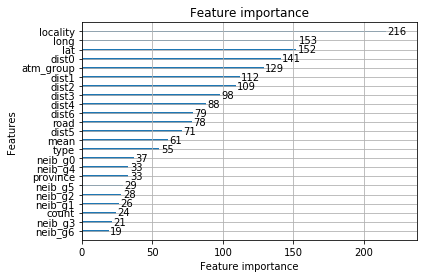

In [288]:
%matplotlib inline
lgb.plot_importance(gbm)

In [23]:
submit = pd.DataFrame(ans, index=original_test.index,columns=['target'])

In [24]:
submit.to_csv('submits/baseline_my_ds.csv')

### Sklearn 

In [153]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

In [154]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [158]:
regr = RandomForestRegressor(n_estimators=100)

In [159]:
regr.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [160]:
rmse(Y_valid,regr.predict(X_valid))

0.0437659492246136